In [ ]:
!pip install d2l==0.14
!pip install git+https://github.com/d2l-ai/d2l-zh@release 

VGG块

In [4]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs,in_channels,out_channels):
  layers=[]
  for _ in range(num_convs):
    layers.append(nn.Conv2d(
        in_channels,out_channels,kernel_size=3,padding=1
    ))
    layers.append(nn.ReLU())
    in_channels=out_channels
  layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
  return nn.Sequential(*layers)

VGG网络

In [6]:
conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))

def vgg(conv_arch):
  conv_blks=[]
  in_channels=1
  for (num_convs,out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
    in_channels=out_channels
  
  return nn.Sequential(
      *conv_blks,nn.Flatten(),
      nn.Linear(out_channels*7*7,4096),nn.ReLU(),
      nn.Dropout(0.5),nn.Linear(4096,4096),nn.ReLU(),
      nn.Dropout(0.5),nn.Linear(4096,10)
  )

net=vgg(conv_arch)

观察每个层输出的形状

In [7]:
X=torch.randn(size=(1,1,224,224))
for blk in net:
  X=blk(X)
  print(blk.__class__.__name__,'output shape:\t',X.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


由于VGG11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络

In [8]:
ratio=4
small_conv_arch=[(pair[0],pair[1]//ratio) for pair in conv_arch]
net=vgg(small_conv_arch)

模型训练

loss 0.177, train acc 0.935, test acc 0.917
376.8 examples/sec on cuda:0


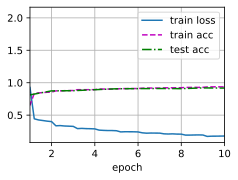

In [9]:
lr,num_epochs,batch_size=0.05,10,128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=224)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())